In [2]:
# import the required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Part 1: Preparation and exploration of data

### Step 1.1 Load and Explore the data

In this section, I have loaded the data and used histograms to visualize the categorical data that I have


In [3]:
# Load the data
file_path = 'HR data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
print(data.describe())

        employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min    

In [5]:
# View classes of the target variable
print(data.groupby('KPIs_met >80%').size())
print(data.groupby('awards_won?').size())
print(data.groupby('gender').size())
print(data.groupby('recruitment_channel').size())
print(data.groupby('region').size())
print(data.groupby('department').size())
print(data.groupby('is_promoted').size())

KPIs_met >80%
0    35517
1    19291
dtype: int64
awards_won?
0    53538
1     1270
dtype: int64
gender
f    16312
m    38496
dtype: int64
recruitment_channel
other       30446
referred     1142
sourcing    23220
dtype: int64
region
region_1       610
region_10      648
region_11     1315
region_12      500
region_13     2648
region_14      827
region_15     2808
region_16     1465
region_17      796
region_18       31
region_19      874
region_2     12343
region_20      850
region_21      411
region_22     6428
region_23     1175
region_24      508
region_25      819
region_26     2260
region_27     1659
region_28     1318
region_29      994
region_3       346
region_30      657
region_31     1935
region_32      945
region_33      269
region_34      292
region_4      1703
region_5       766
region_6       690
region_7      4843
region_8       655
region_9       420
dtype: int64
department
Analytics             5352
Finance               2536
HR                    2418
Legal            

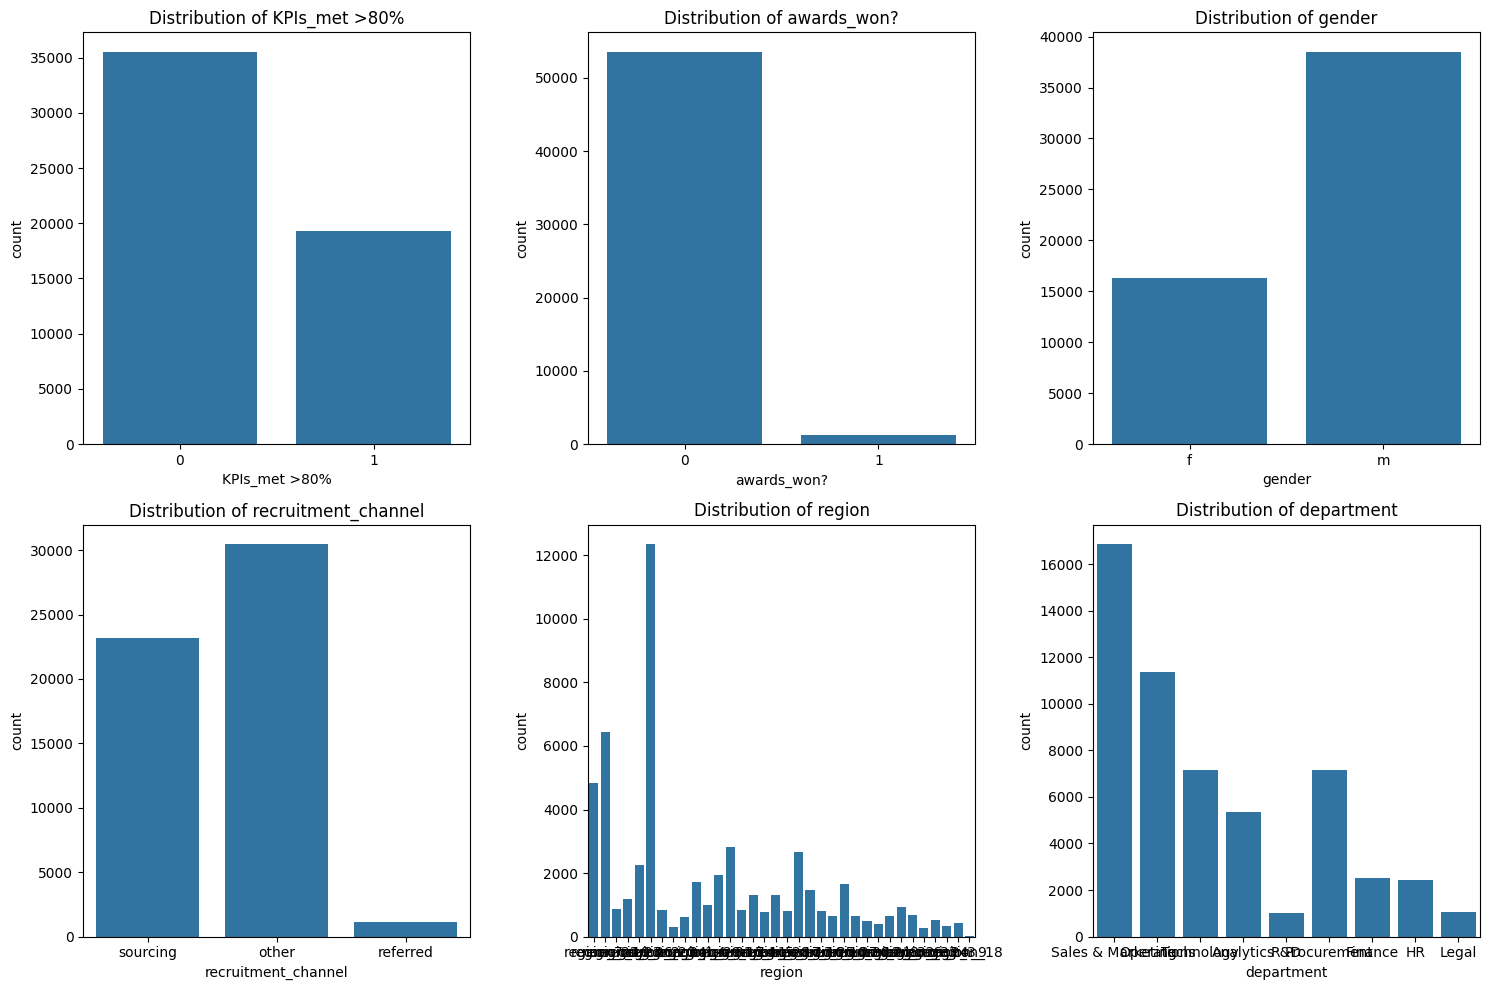

In [6]:
# Visualize distributions of categorical variables
categorical_columns = ['KPIs_met >80%', 'awards_won?', 'gender', 'recruitment_channel', 'region', 'department']

# Determine the number of rows and columns for the subplots
n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, col in enumerate(categorical_columns):
    row = i // n_cols
    col_num = i % n_cols
    sns.countplot(x=col, data=data, ax=axes[row, col_num])
    axes[row, col_num].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

### Step 1.2 Cleanse and Transform the data

In this section I identified 2 columns with null values - 'education' & 'previous_year_rating'
- I assume that null value for education can be replaced with diploma as it would be a logical fit between bachelor's degree and secondary school 
- I also assume that employees with null value in 'previous_year_rating' are new employees, hence it would make sense to use median value as a starting point for their performance

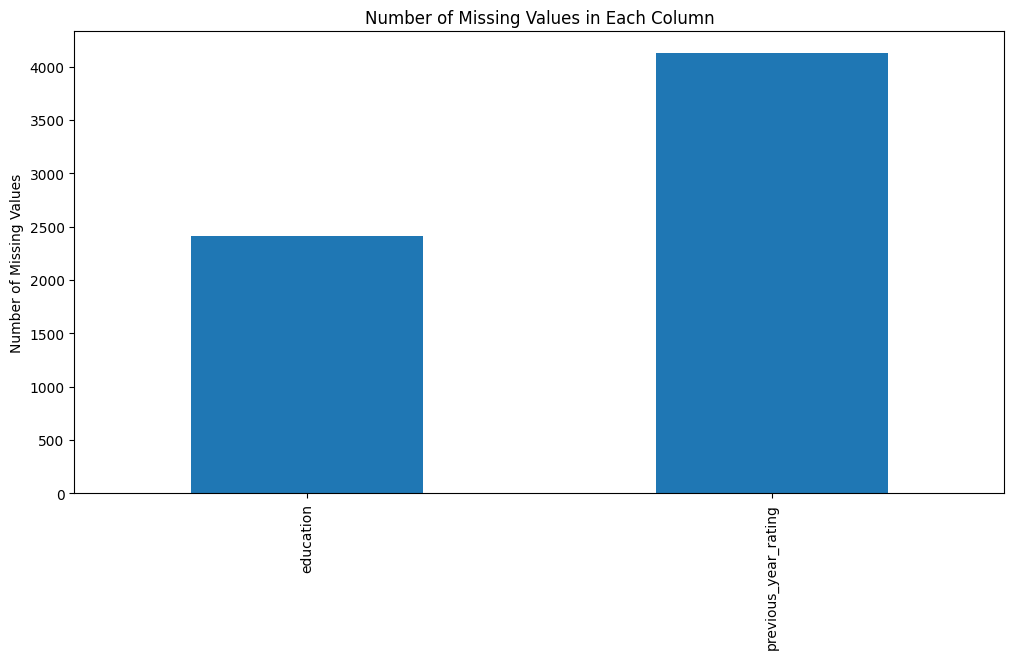

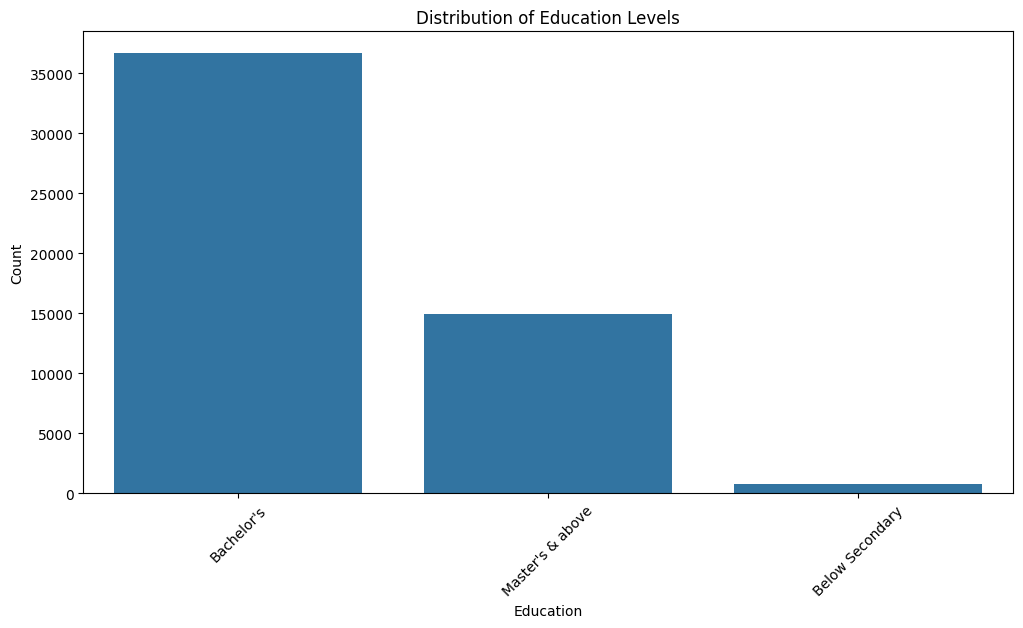

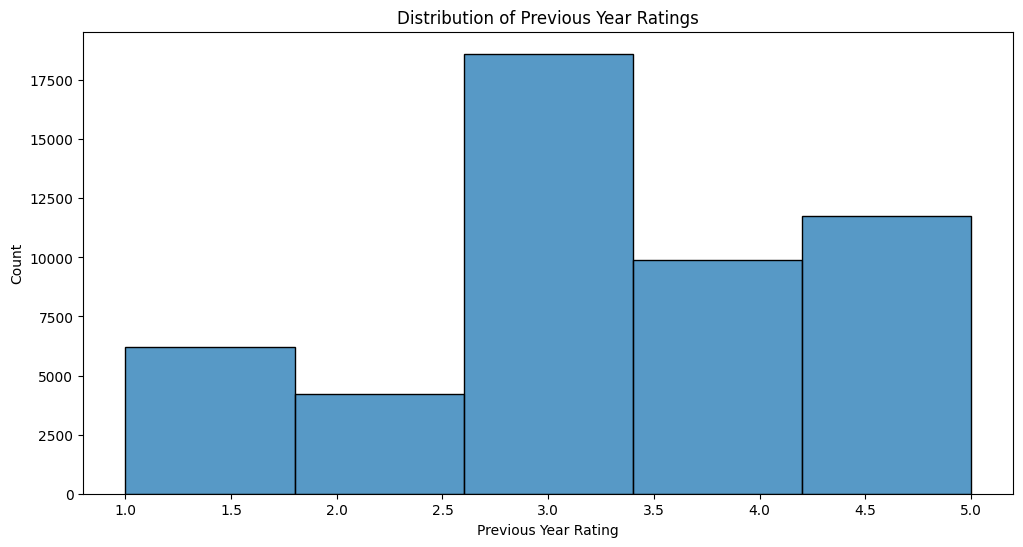

In [7]:
# Checking for missing values
missing_values = data.isnull().sum()

# Use a bar plot for a clearer view of the number of missing values in each column
missing_values[missing_values > 0].plot(kind='bar', figsize=(12, 6))
plt.title('Number of Missing Values in Each Column')
plt.ylabel('Number of Missing Values')
plt.show()

# Visualize the distribution of the 'education' variable
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='education', order=data['education'].value_counts().index)
plt.title('Distribution of Education Levels')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Visualize the distribution of the 'previous_year_rating' variable
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='previous_year_rating', bins=5, kde=False)
plt.title('Distribution of Previous Year Ratings')
plt.xlabel('Previous Year Rating')
plt.ylabel('Count')
plt.show()

Missing values in 'education' column after filling: 0


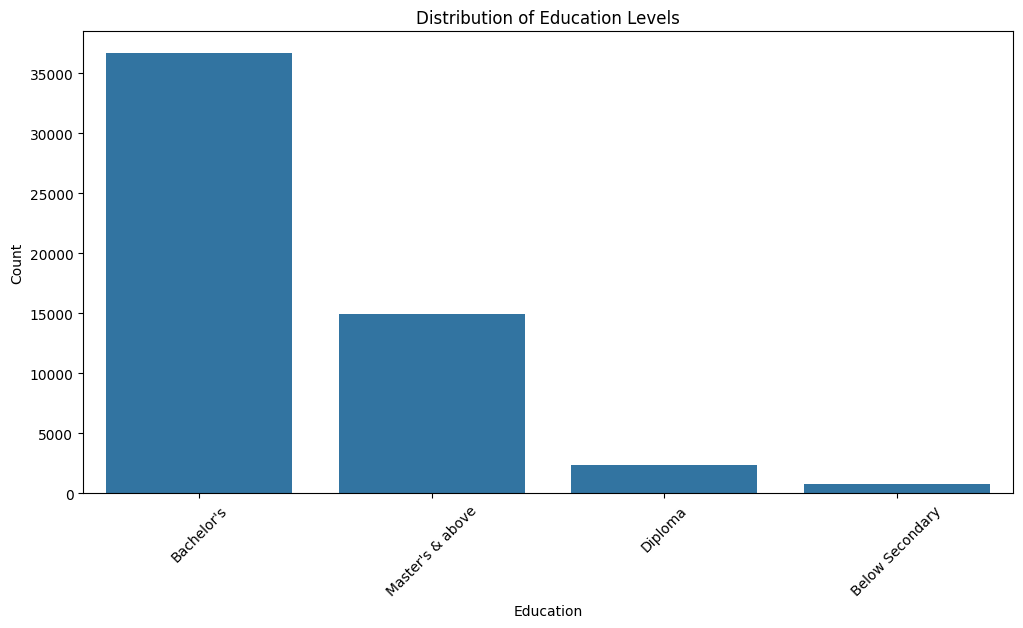

In [8]:
# Assuming that for education, a missing value means the employee has only a Diploma
data['education'].fillna('Diploma', inplace=True)

# Verify the changes
missing_values_after_fill = data['education'].isnull().sum()
print(f"Missing values in 'education' column after filling: {missing_values_after_fill}")

# Visualize the distribution of the 'education' variable
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='education', order=data['education'].value_counts().index)
plt.title('Distribution of Education Levels')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Missing values in 'previous_year_rating' column after filling: 0


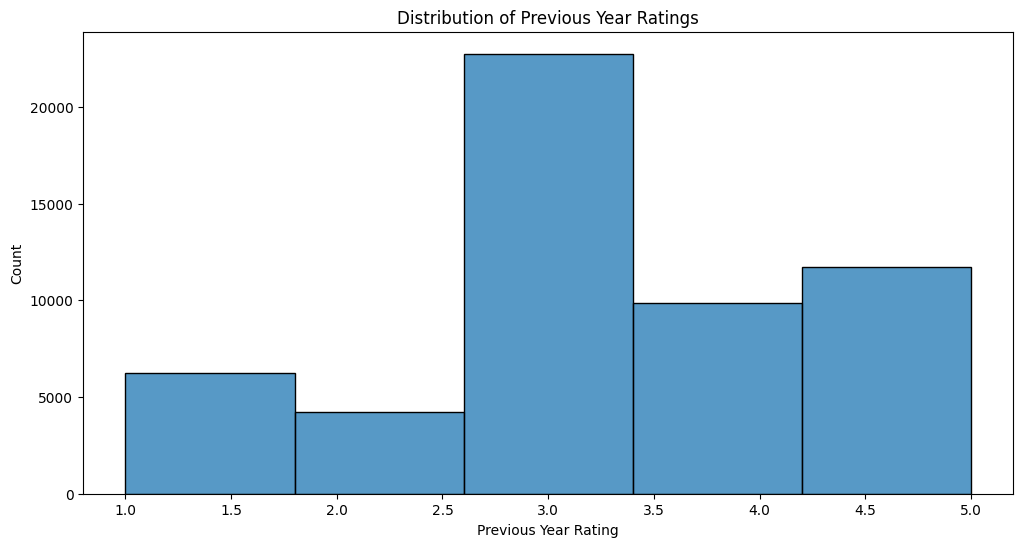

In [9]:
# Fill missing values in 'previous_year_rating' with the median value AKA numerical imputation
median_previous_year_rating = data['previous_year_rating'].median()
data['previous_year_rating'].fillna(median_previous_year_rating, inplace=True)

# Verify the changes
missing_values_after_fill = data.isnull().sum()
print(f"Missing values in 'previous_year_rating' column after filling: {missing_values_after_fill['previous_year_rating']}")

# Visualize the distribution of the 'previous_year_rating' variable
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='previous_year_rating', bins=5, kde=False)
plt.title('Distribution of Previous Year Ratings')
plt.xlabel('Previous Year Rating')
plt.ylabel('Count')
plt.show()

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object


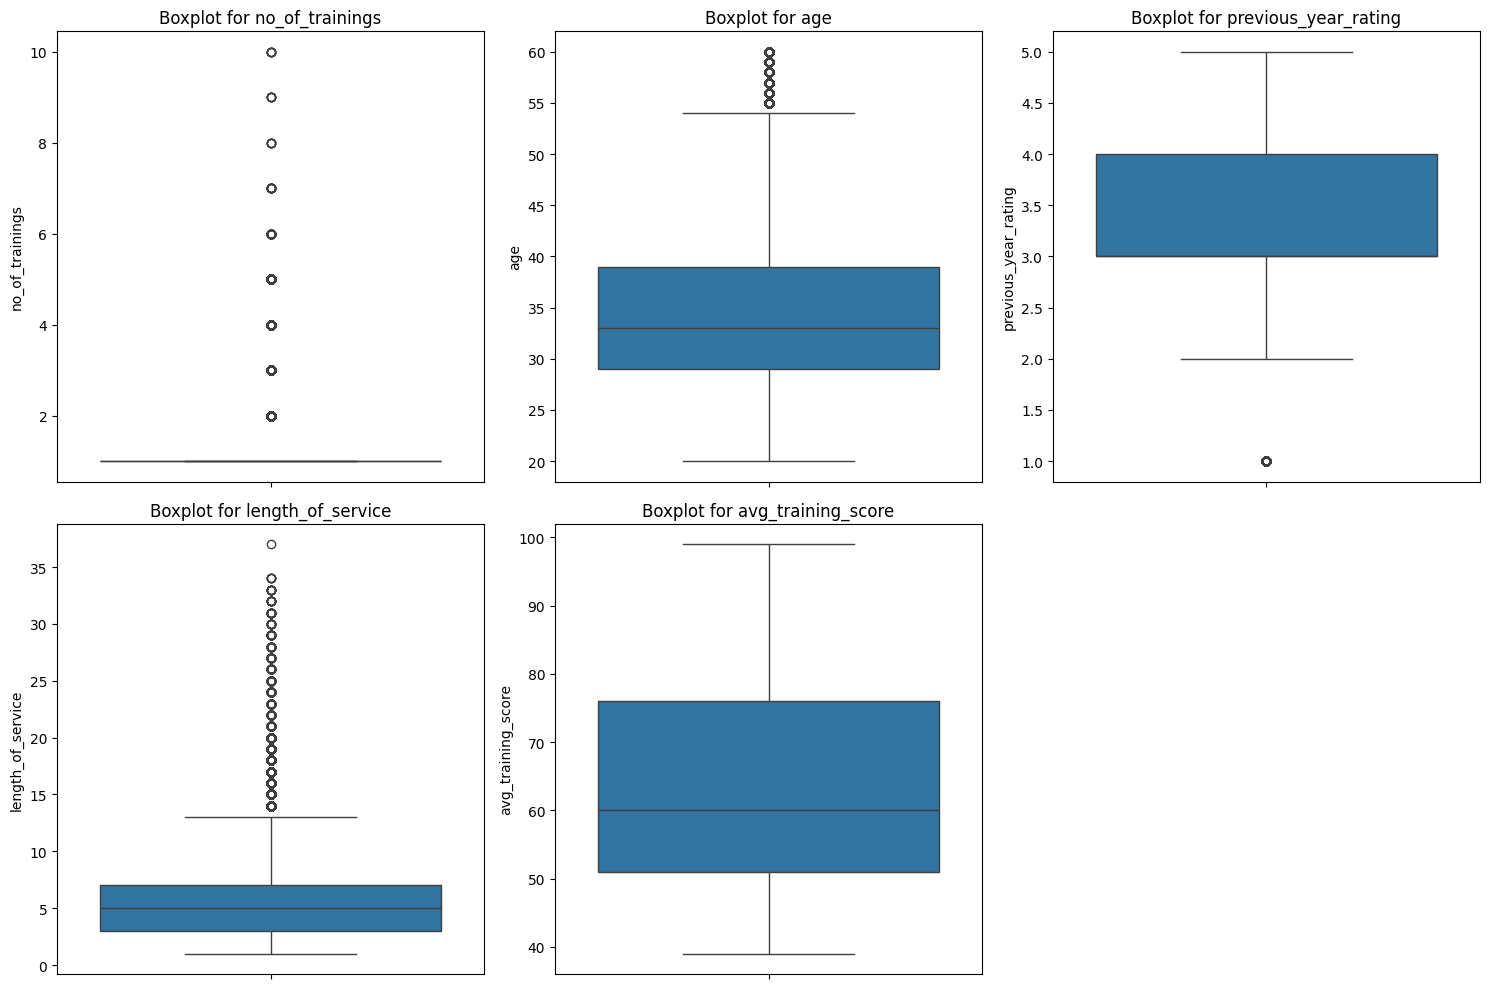

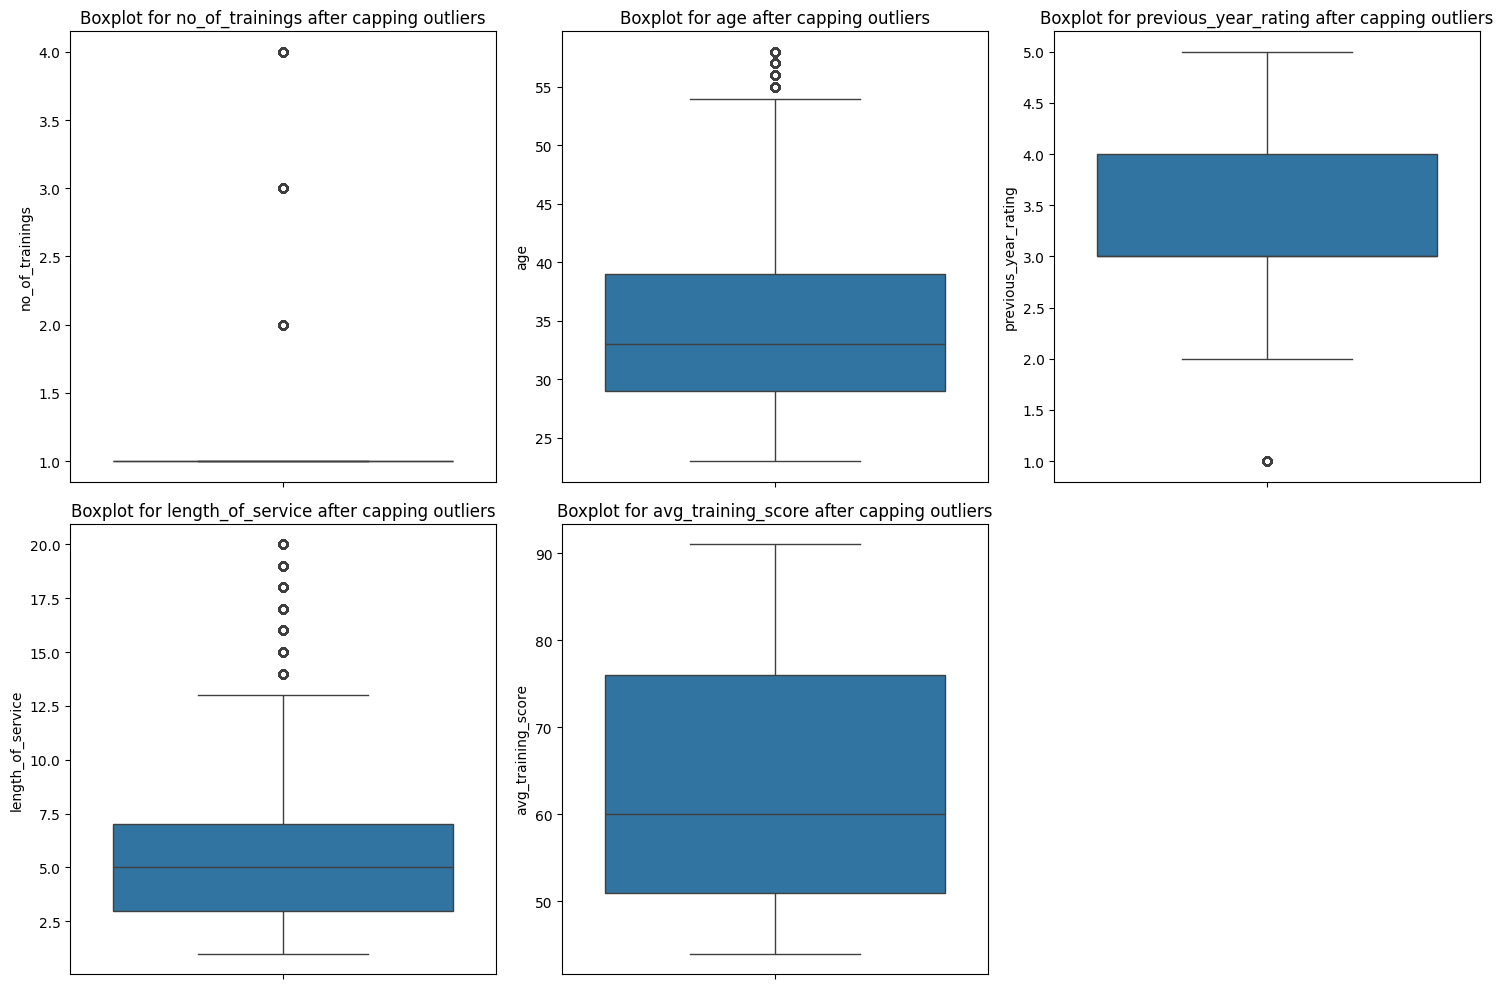

In [10]:
# Verify data types and correct if necessary
print(data.dtypes)

# Remove duplicates if any
data.drop_duplicates(inplace=True)

# List of numerical columns
numerical_columns = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']

# Create a grid of boxplots
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

# Cap outliers at the 1st and 99th percentiles
for col in numerical_columns:
    lower_limit = data[col].quantile(0.01)
    upper_limit = data[col].quantile(0.99)
    data[col] = data[col].clip(lower_limit, upper_limit)

# Create a grid of boxplots after capping outliers
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot for {col} after capping outliers')

plt.tight_layout()
plt.show()

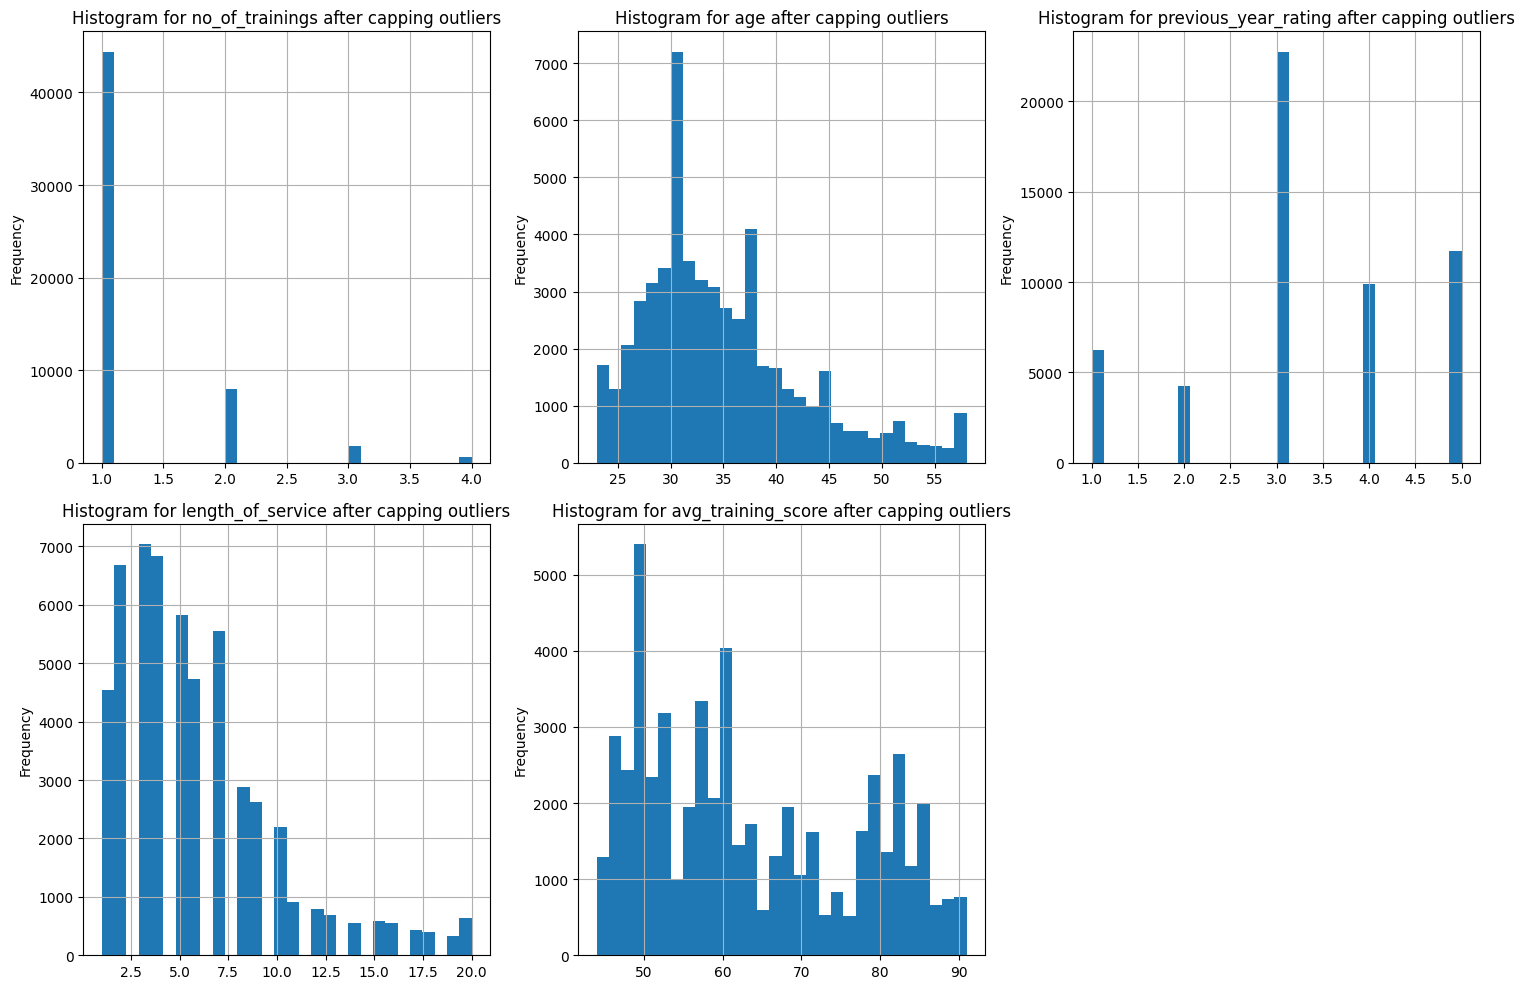

In [11]:
# Create a grid of histograms after capping outliers
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    data[col].hist(bins=30)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for {col} after capping outliers')

plt.tight_layout()
plt.show()

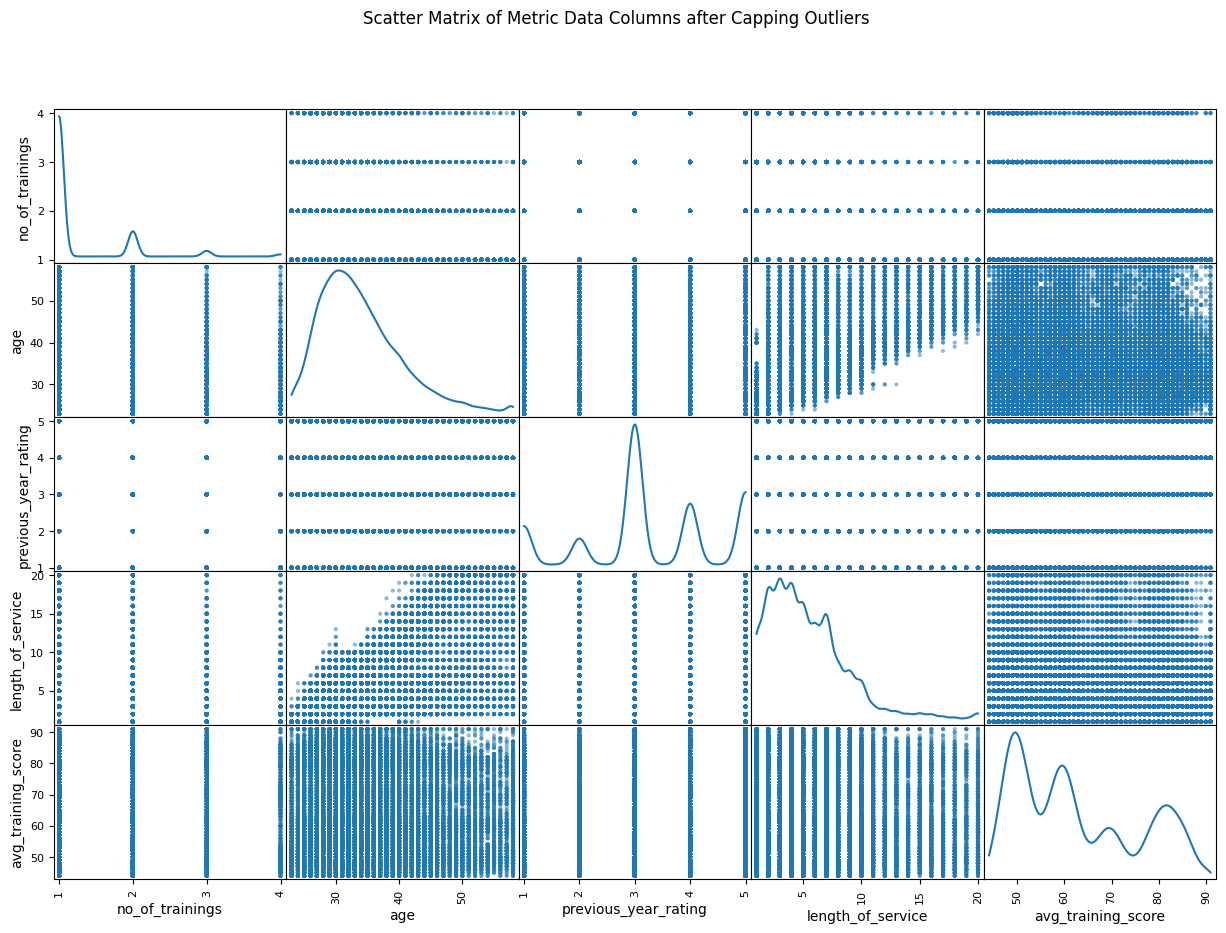

In [12]:
# Create a scatter matrix plot
pd.plotting.scatter_matrix(data[numerical_columns], figsize=(15, 10), diagonal='kde')
plt.suptitle('Scatter Matrix of Metric Data Columns after Capping Outliers')
plt.show()

### Step 1.3 Correlation Analysis

- I use scatterplot to try and notice any diagonal relationship between numerical data
- I use point biserial correlation for binary outcome (assuming 'is_promoted' is the goal)
- 'avg_training_score' and 'previous_year_rating' are likely more important features compared to other numerical data

Correlation between 'no_of_trainings' and 'avg_training_score': 0.04798066948787277


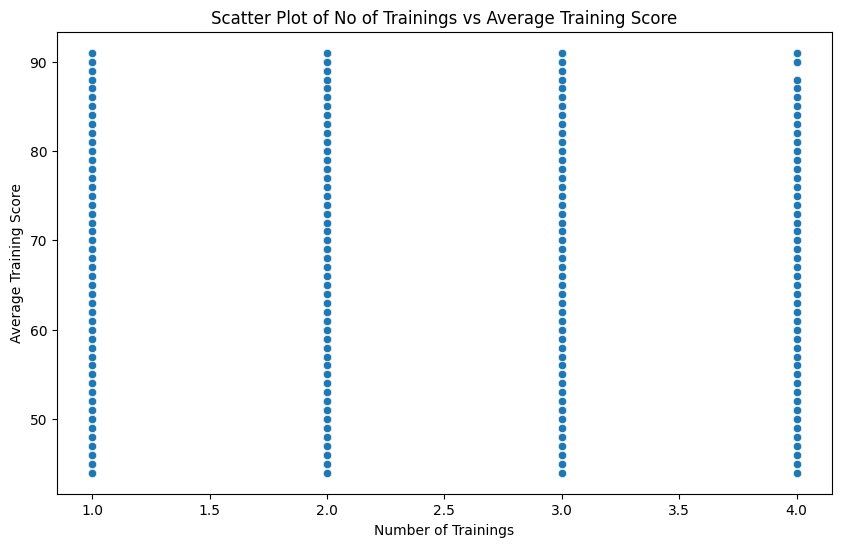

In [13]:
# Calculate the correlation coefficient
correlation = data['no_of_trainings'].corr(data['avg_training_score'])
print(f"Correlation between 'no_of_trainings' and 'avg_training_score': {correlation}")

# Visualize the relationship with a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='no_of_trainings', y='avg_training_score', data=data)
plt.title('Scatter Plot of No of Trainings vs Average Training Score')
plt.xlabel('Number of Trainings')
plt.ylabel('Average Training Score')
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


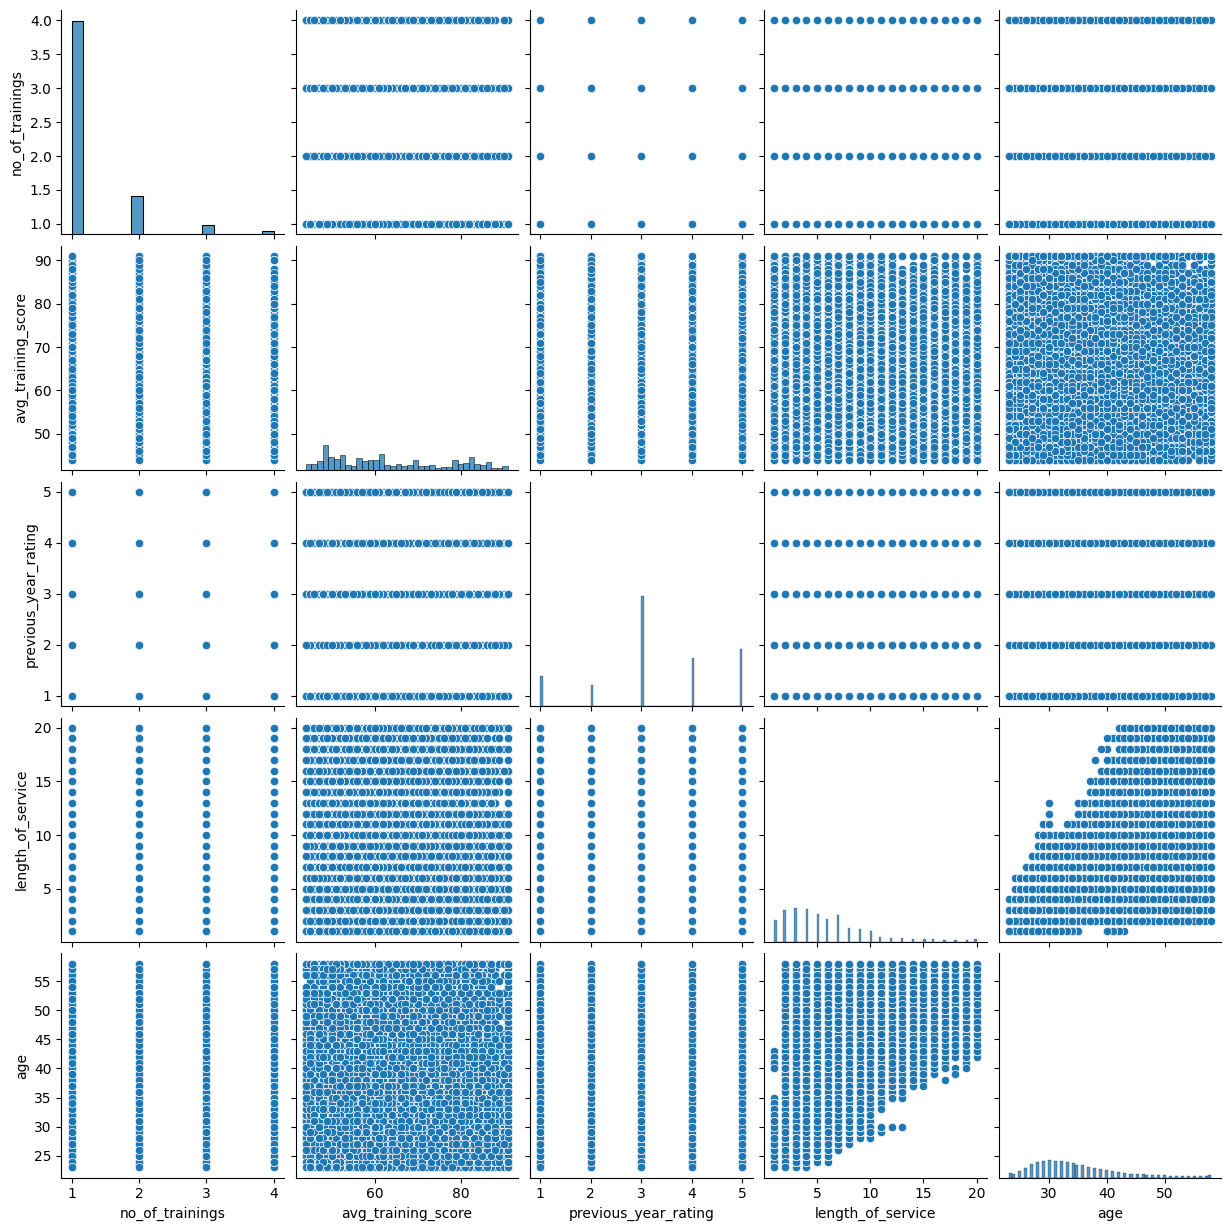

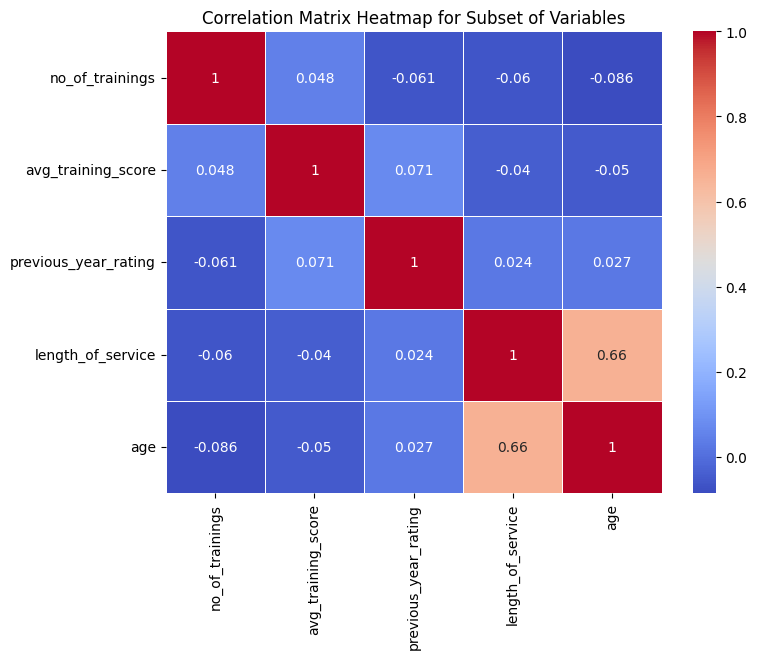

In [14]:
# Visualize pairwise relationships
sns.pairplot(data[['no_of_trainings', 'avg_training_score', 'previous_year_rating', 'length_of_service', 'age']])
plt.show()

# Calculate the correlation matrix for a subset of variables
subset = data[['no_of_trainings', 'avg_training_score', 'previous_year_rating', 'length_of_service', 'age']]
correlation_matrix_subset = subset.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap for Subset of Variables')
plt.show()


In [15]:
# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(data['no_of_trainings'], data['avg_training_score'])
print(f"Correlation: {correlation}, P-value: {p_value}")


Correlation: 0.04798066948787278, P-value: 2.622681327245577e-29


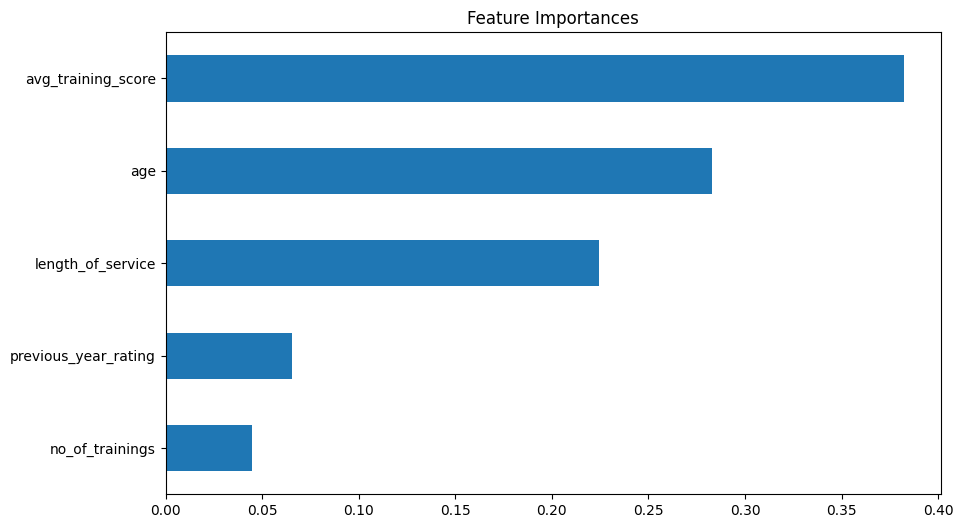

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Assuming 'is_promoted' is the target variable
X = data[['no_of_trainings', 'avg_training_score', 'previous_year_rating', 'length_of_service', 'age']]
y = data['is_promoted']

# Train a Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_
features = X.columns
importances = pd.Series(feature_importances, index=features)

# Visualize feature importances
importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()


In [17]:
# Calculate point biserial correlation for binary outcome
for col in numerical_columns:
    corr, p_value = pointbiserialr(data[col], data['is_promoted'])
    print(f'Correlation between {col} and is_promoted: {corr:.2f} (p-value: {p_value:.3f})')
    
# -----------------------------------------------------------------------------------------------------------------------
# There is a very weak negative correlation between the number of trainings and the likelihood of promotion. 
# This suggests that an increase in the number of trainings is slightly associated with a lower chance of being promoted.
# -----------------------------------------------------------------------------------------------------------------------
# There is a very weak negative correlation between age and the likelihood of promotion. 
# This suggests that older employees are slightly less likely to be promoted.
# -----------------------------------------------------------------------------------------------------------------------
# There is a weak positive correlation between the previous year's rating and the likelihood of promotion. 
# This suggests that higher ratings in the previous year are somewhat associated with a higher chance of being promoted.
# -----------------------------------------------------------------------------------------------------------------------
# There is a very weak negative correlation between the length of service and the likelihood of promotion. 
# This suggests that employees with longer tenure are slightly less likely to be promoted.
# -----------------------------------------------------------------------------------------------------------------------
# There is a weak positive correlation between the average training score and the likelihood of promotion. 
# This suggests that employees with higher training scores are somewhat more likely to be promoted.
# -----------------------------------------------------------------------------------------------------------------------

Correlation between no_of_trainings and is_promoted: -0.02 (p-value: 0.000)
Correlation between age and is_promoted: -0.02 (p-value: 0.000)
Correlation between previous_year_rating and is_promoted: 0.15 (p-value: 0.000)
Correlation between length_of_service and is_promoted: -0.01 (p-value: 0.021)
Correlation between avg_training_score and is_promoted: 0.17 (p-value: 0.000)


### Step 1.4 Export the data

- I export data to hr_data_new.csv which is another csv file within the same folder

In [18]:
# Export the cleaned data to a new CSV file
export_path = 'hr_data_new.csv'
data.to_csv(export_path, index=False)

print(f"Data has been exported to {export_path}")

Data has been exported to hr_data_new.csv


## Part 2: Building machine learning models

### Step 2.1 Load and Sample data

- I load the appropriate data using new file, and ensure that the categorical data is encoded
- I standardize the data and split the data

In [19]:
# Load the cleaned data
file_path = 'hr_data_new.csv'
data = pd.read_csv(file_path)

# Display the first few rows to verify the data
print(data.head())

# Display basic information about the dataset
print(data.info())

# Display descriptive statistics
print(data.describe())

# Identify categorical columns
categorical_columns = ['KPIs_met >80%', 'awards_won?', 'gender', 'recruitment_channel', 'region', 'department', 'education']

# Perform one-hot encoding on categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Separate features and target variable
X = data_encoded.drop(columns=['is_promoted'])
y = data_encoded['is_promoted']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Display the shapes of the training and testing sets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


   employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1 

### Step 2.2 Build the Classification Model(s)

- I spot check algorithms before building models to see which models are the most appropriate
- LDA seems to be best performing algorithm followed by LR
- SVM data is close to LR however has extremely long load time

In [20]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='linear', gamma='auto')))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# LDA seems to best performing Algorithm


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\User\AppData\

LR: 0.931761 (0.002117)
LDA: 0.934042 (0.001978)
KNN: 0.911668 (0.001587)
CART: 0.897414 (0.003740)
NB: 0.251448 (0.007588)
SVM: 0.925991 (0.001859)


### Step 2.3 Evaluate and Improve the Model(s) Performance

#### Step 2.3.1 Evaluate LDA Model

In [21]:
# Initialize the LDA model
model = LinearDiscriminantAnalysis()

# Train the model on the entire training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print("The Linear Discriminant Analysis (LDA) model achieved an overall accuracy of 93.59%")
print("The confusion matrix shows that the model correctly identified 99.37% of non-promoted employees but only 29.52% of promoted employees")
print("The precision for identifying promoted employees is 81%, but the recall is low at 30%")
print("This suggests that while the model is good at identifying non-promoted employees, it struggles to correctly identify all promoted employees.")

Accuracy: 0.9358693669038497
Confusion Matrix:
[[9991   63]
 [ 640  268]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10054
           1       0.81      0.30      0.43       908

    accuracy                           0.94     10962
   macro avg       0.87      0.64      0.70     10962
weighted avg       0.93      0.94      0.92     10962

The Linear Discriminant Analysis (LDA) model achieved an overall accuracy of 93.59%
The confusion matrix shows that the model correctly identified 99.37% of non-promoted employees but only 29.52% of promoted employees
The precision for identifying promoted employees is 81%, but the recall is low at 30%
This suggests that while the model is good at identifying non-promoted employees, it struggles to correctly identify all promoted employees.


In [22]:
# Define the parameter grid
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']
}

# Initialize the model
model = LinearDiscriminantAnalysis()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the best model on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")


Best Parameters: {'solver': 'svd'}
Best Score: 0.9338366164096248
Accuracy: 0.9358693669038497
Confusion Matrix:
[[9991   63]
 [ 640  268]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10054
           1       0.81      0.30      0.43       908

    accuracy                           0.94     10962
   macro avg       0.87      0.64      0.70     10962
weighted avg       0.93      0.94      0.92     10962



In [23]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']
}

# Initialize the model
model = LinearDiscriminantAnalysis()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the best model on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")


Best Parameters: {'solver': 'svd'}
Best Score: 0.9338366164096248
Accuracy: 0.9358693669038497
Confusion Matrix:
[[9991   63]
 [ 640  268]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10054
           1       0.81      0.30      0.43       908

    accuracy                           0.94     10962
   macro avg       0.87      0.64      0.70     10962
weighted avg       0.93      0.94      0.92     10962



Most important features for predicting promotion:
                         Feature  Importance
50  department_Sales & Marketing    6.312694
5             avg_training_score    5.292923
47         department_Operations    3.886527
45                 department_HR    2.712421
48        department_Procurement    1.993834
44            department_Finance    1.980982
46              department_Legal    1.257111
6                KPIs_met >80%_1    0.809036
51         department_Technology    0.770246
7                  awards_won?_1    0.493165


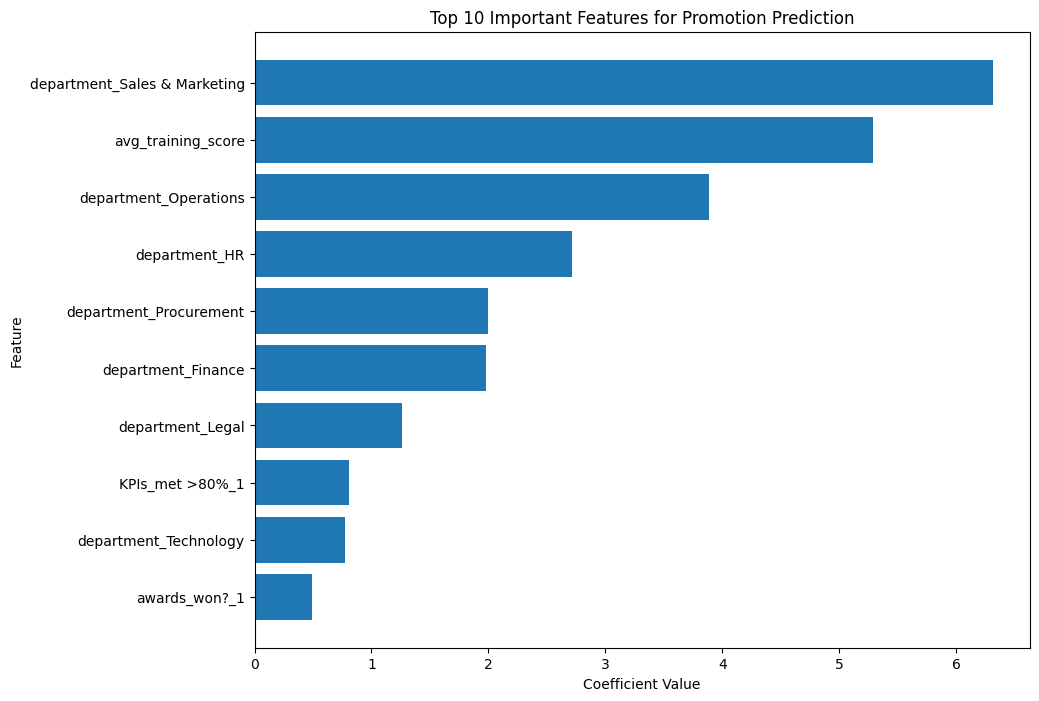

In [24]:
# Initialize and fit the LDA model
model = LinearDiscriminantAnalysis(solver='svd')
model.fit(X_train, y_train)

# Extract feature importances (coefficients)
feature_importance = model.coef_[0]
feature_names = X.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Importance'].abs().sort_values(ascending=False).index)

# Display the most important features
print("Most important features for predicting promotion:")
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Important Features for Promotion Prediction')
plt.gca().invert_yaxis()
plt.show()

#### Step 2.3.2 Evaluate LR Model


In [25]:
# Select specific features
selected_features = ['awards_won?', 'KPIs_met >80%', 'avg_training_score']
X = data[selected_features]
y = data['is_promoted']

# Standardize the features (optional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.9177157453019522
Confusion Matrix:
[[10016    38]
 [  864    44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10054
           1       0.54      0.05      0.09       908

    accuracy                           0.92     10962
   macro avg       0.73      0.52      0.52     10962
weighted avg       0.89      0.92      0.89     10962



In [26]:
# Select specific features
selected_features = ['awards_won?', 'KPIs_met >80%', 'avg_training_score']
X = data[selected_features]
y = data['is_promoted']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [100, 200, 500]
}

# Initialize the GridSearchCV with Logistic Regression
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Train the best model on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Best Parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Best Cross-Validation Score: 0.9142909325088014
Accuracy: 0.9177157453019522
Confusion Matrix:
[[10016    38]
 [  864    44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10054
           1       0.54      0.05      0.09       908

    accuracy                           0.92     10962
   macro avg       0.73      0.52      0.52     10962
weighted avg       0.89      0.92      0.89     10962



### Step 2.4 Summarize the findings


### Interpretation

1. **Overall Accuracy**:
 - The Logistic Regression model achieved an overall accuracy of 91.77%, which is quite good.

2. **Performance on Non-Promoted Employees (Class 0)**:
 - **Precision**: 0.92 (92%)
 - **Recall**: 1.00 (100%)
 - **F1-Score**: 0.96 (96%)
 - The model performs exceptionally well in identifying non-promoted employees, with both high precision and recall.

3. **Performance on Promoted Employees (Class 1)**:
 - **Precision**: 0.54 (54%)
 - **Recall**: 0.05 (5%)
 - **F1-Score**: 0.09 (9%)
 - The model struggles significantly with identifying promoted employees, with very low recall (5%) and moderate precision (54%).

4. **Class Imbalance**:
 - The performance metrics indicate that the model is highly influenced by the class imbalance, performing well on the majority class (non-promoted) but poorly on the minority class (promoted).

### Comparison with LDA

1. **Accuracy**:
 - **LDA**: 93.59%
 - **Logistic Regression**: 91.77%
 - LDA has a slightly higher accuracy compared to Logistic Regression.

2. **Performance on Promoted Employees (Class 1)**:
 - **LDA**: Precision (81%), Recall (30%)
 - **Logistic Regression**: Precision (54%), Recall (5%)
 - LDA performs significantly better in identifying promoted employees compared to Logistic Regression.

3. **Class Imbalance**:
 - Both models are affected by class imbalance, but LDA handles it better than Logistic Regression in this case.

### Conclusion

- **LDA** remains the better model for predicting promotions in this dataset, given its higher accuracy and better performance on the minority class (promoted employees).
- **Logistic Regression** with selected features also performs well overall, but it struggles significantly with recall for promoted employees.


Most important features for predicting promotion:
                         Feature  Importance
50  department_Sales & Marketing    6.312694
5             avg_training_score    5.292923
47         department_Operations    3.886527
45                 department_HR    2.712421
48        department_Procurement    1.993834
44            department_Finance    1.980982
46              department_Legal    1.257111
6                KPIs_met >80%_1    0.809036
51         department_Technology    0.770246
7                  awards_won?_1    0.493165


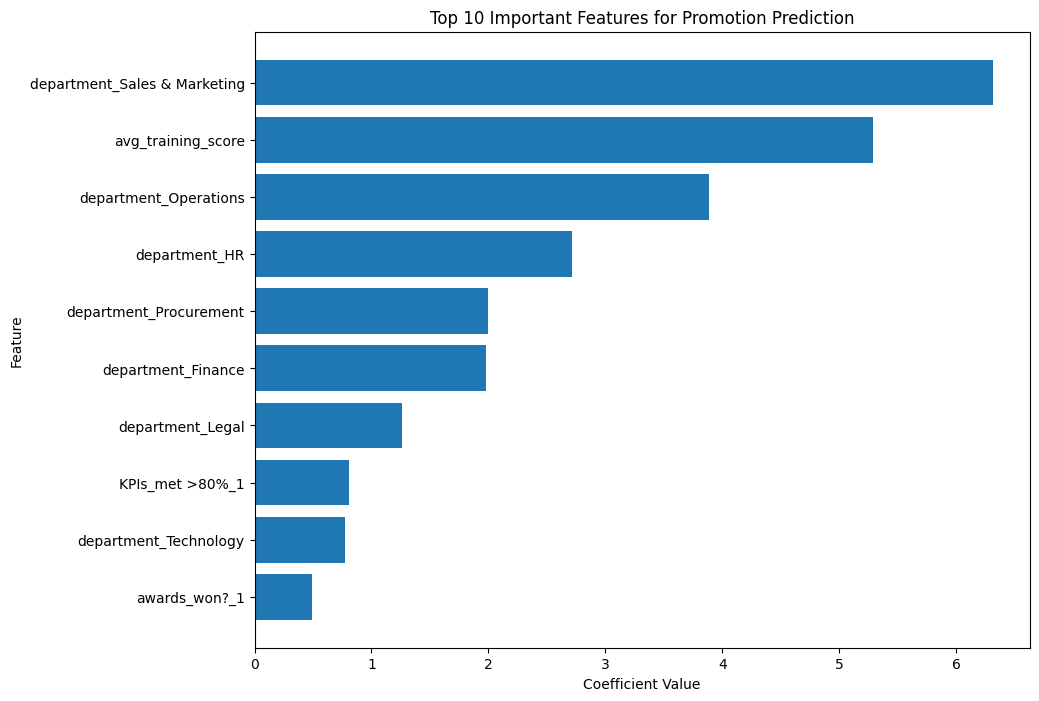

In [27]:
# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Importance'].abs().sort_values(ascending=False).index)

# Display the most important features
print("Most important features for predicting promotion:")
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Important Features for Promotion Prediction')
plt.gca().invert_yaxis()
plt.show()